In [2]:
#importing sys
import sys
  
# adding src to the system path
sys.path.insert(0, '../src')

Logistic Regression Test Accuracy: 0.9824561403508771


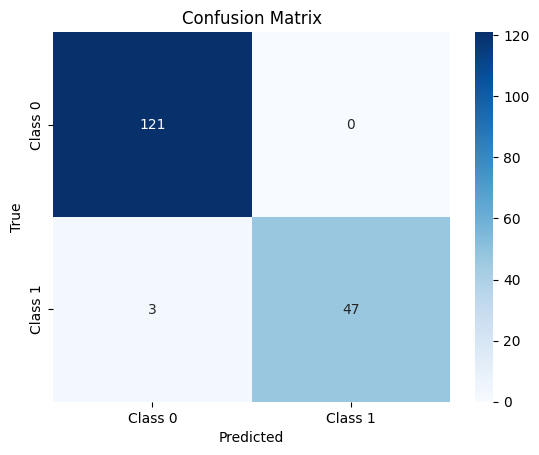

Single Series Classifier Accuracy: 0.935672514619883
Multi-Series Classifier Accuracy: 0.9707602339181286


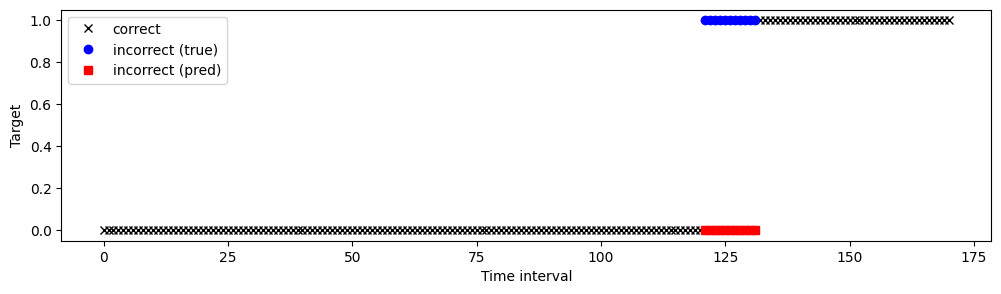

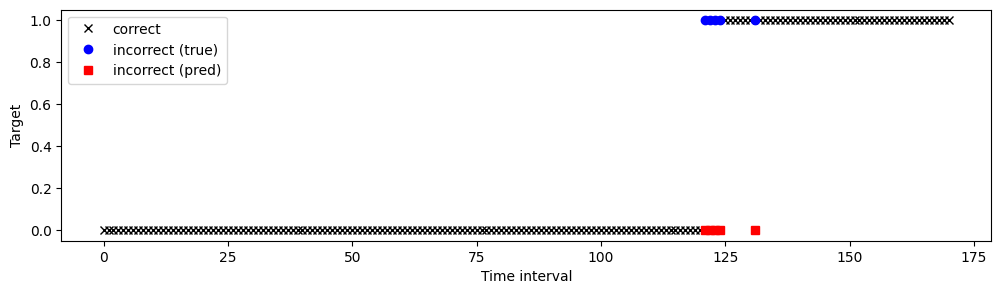

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from ml_pipeline.featureset import make_summary_stats_input, make_series_input
from ml_pipeline.model import processing_pipeline, train_traditional_model, train_series_model, train_multiseries_model, test_model, plot_model_result

# Load the data
train = pd.read_csv('../input/train/data.csv', parse_dates=['Time']).set_index('Time')
test = pd.read_csv('../input/test/data.csv', parse_dates=['Time']).set_index('Time')

# Dictionary to store data splits
data_dict = {'stat': {}, '1col': {}, 'ts': {}}

# Process data for Logistic Regression using summary statistics
data_dict['stat']['X_train'], data_dict['stat']['y_train'] = processing_pipeline(
    train[-3100:-2900],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_summary_stats_input
)

data_dict['stat']['X_test'], data_dict['stat']['y_test'] = processing_pipeline(
    test[4200:4400],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_summary_stats_input
)

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)  # Ensure convergence

# Hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to test
    'penalty': ['l2', 'l1'],  # Regularization type
    'fit_intercept': [True, False],  # Include intercept
    'class_weight': ['balanced', None]  # Class imbalance handling
}

# Grid Search for Logistic Regression
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(data_dict['stat']['X_train'], data_dict['stat']['y_train'])

# Get best model from grid search
best_log_reg = grid_search.best_estimator_

# Evaluate Logistic Regression on the test set
y_pred = best_log_reg.predict(data_dict['stat']['X_test'])
accuracy = accuracy_score(data_dict['stat']['y_test'], y_pred)
print(f"Logistic Regression Test Accuracy: {accuracy}")

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(data_dict['stat']['y_test'], y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Process data for Single Series Classifier (1col)
data_dict['1col']['X_train'], data_dict['1col']['y_train'] = processing_pipeline(
    train[-3100:-2900][['Temperature', 'Status']],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_series_input,
    add_first_diffs=False
)

data_dict['1col']['X_test'], data_dict['1col']['y_test'] = processing_pipeline(
    test[4200:4400][['Temperature', 'Status']],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_series_input,
    add_first_diffs=False
)

# Train and evaluate Single Series Classifier
model_1col = train_series_model(X=data_dict['1col']['X_train'], y=data_dict['1col']['y_train'])
result_1col = test_model(data_dict['1col']['X_test'], data_dict['1col']['y_test'].values, model_1col, threshold=0.50)

print(f"Single Series Classifier Accuracy: {(result_1col['residual'] == 0).mean()}")
plot_model_result(result_1col)

# Process data for Multi-Series Classifier (ts)
data_dict['ts']['X_train'], data_dict['ts']['y_train'] = processing_pipeline(
    train[-3100:-2900],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_series_input,
    add_first_diffs=True
)

data_dict['ts']['X_test'], data_dict['ts']['y_test'] = processing_pipeline(
    test[4200:4400],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_series_input,
    add_first_diffs=True
)

# Train and evaluate Multi-Series Classifier
model_ts = train_multiseries_model(X=data_dict['ts']['X_train'], y=data_dict['ts']['y_train'])
result_ts = test_model(data_dict['ts']['X_test'], data_dict['ts']['y_test'].values, model_ts, threshold=0.50)

print(f"Multi-Series Classifier Accuracy: {(result_ts['residual'] == 0).mean()}")
plot_model_result(result_ts)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Training Logistic Regression...
Logistic Regression - ROC AUC: 0.9929, F1 Score: 0.8636


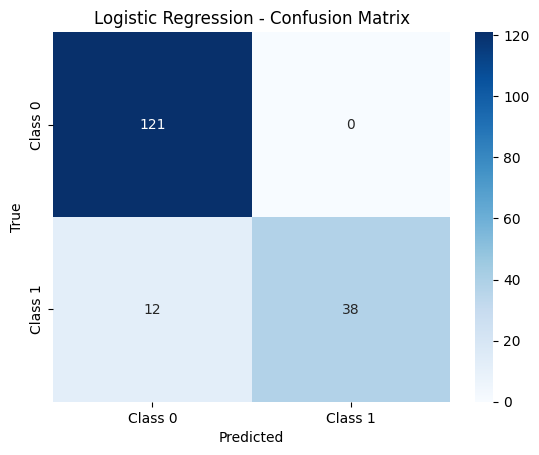


Training Random Forest...
Random Forest - ROC AUC: 1.0000, F1 Score: 0.9899


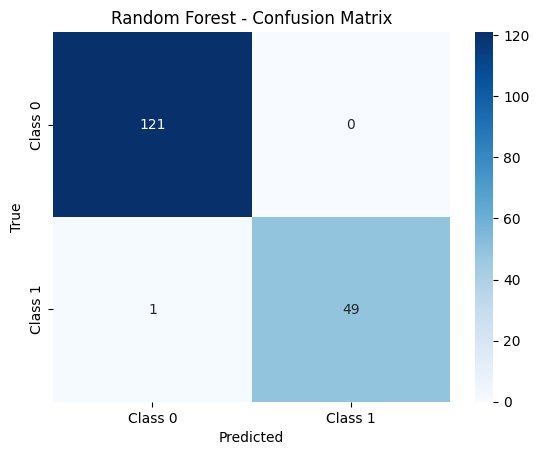


Training SVM...
SVM - ROC AUC: 0.9954, F1 Score: 0.8889


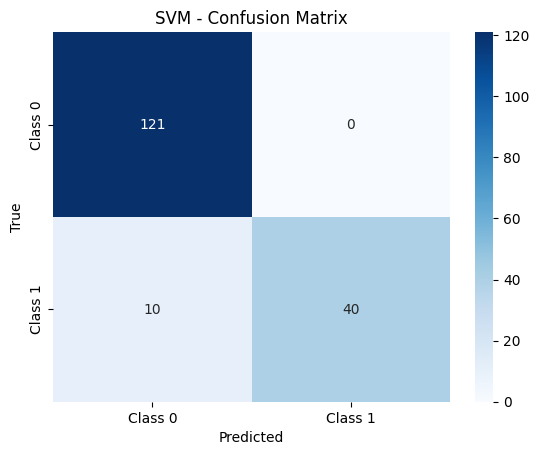


Training 1D Time Series Classifier...


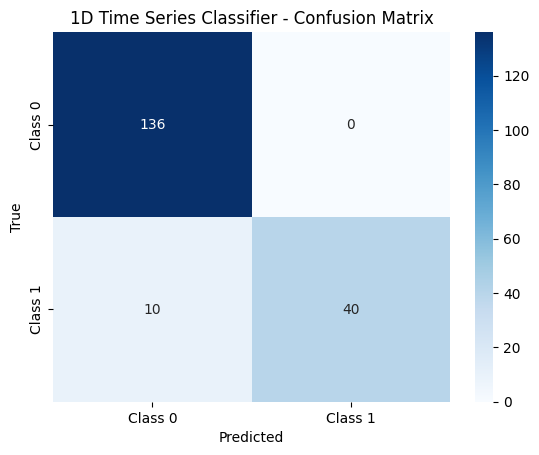

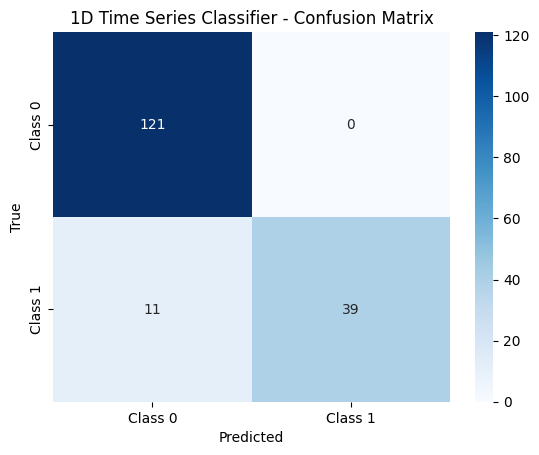

1D Time Series Classifier - ROC AUC: 0.9000, F1 Score: 0.8889
Best hyperparameters: {'window_length': 15}

Best model based on ROC AUC and F1 Score: Random Forest
Best model ROC AUC: 1.0
Best model F1 Score: 0.98989898989899


['best_model.pkl']

In [13]:
# %% 
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
%autoreload 2

# Import necessary libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
import joblib

# Import custom functions
from ml_pipeline.featureset import make_summary_stats_input,make_series_input
from ml_pipeline.model import processing_pipeline,  train_series_model

# %% 
# Load the data
train = pd.read_csv('../input/train/data.csv', parse_dates=['Time']).set_index('Time')
test = pd.read_csv('../input/test/data.csv', parse_dates=['Time']).set_index('Time')

# Prepare the training and testing datasets
# Dictionary to store data splits
data_dict = {'stat': {}, '1col': {}, 'ts': {}}

# Process 'stat' dataset for training and testing
data_dict['stat']['X_train'], data_dict['stat']['y_train'] = processing_pipeline(
    train[-3100:-2900],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_summary_stats_input
)

data_dict['stat']['X_test'], data_dict['stat']['y_test'] = processing_pipeline(
    test[4200:4400],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_summary_stats_input
)

# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    '1D Time Series Classifier':'custom'
}

# Hyperparameters for GridSearchCV
param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l2', 'l1'],
        'fit_intercept': [True, False],
        'class_weight': ['balanced', None]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', None]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    },
    
    '1D Time Series Classifier': {
        'window_length': [15,30]  # Only test window lengths 30 and 60
    }
}

# To store the evaluation metrics for each model
model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    if model_name == '1D Time Series Classifier':
        # GridSearch-like loop to tune window_length
        best_roc_auc = -1  # Store best ROC AUC for window length tuning
        best_f1 = -1  # Store best F1 for window length tuning
        best_model = None  # Store best model
        best_params = None  # Store best parameters

        for window_length in param_grid['1D Time Series Classifier']['window_length']:
            # Process dataset with the current window_length
            data_dict['1col']['X_train'], data_dict['1col']['y_train'] = processing_pipeline(
                train[-3100:-2900][['Temperature', 'Status']],  # Use fixed features
                window_kwargs={'window_length': window_length, 'step_length': 1, 'fh': 0},
                feature_func=make_series_input,
                add_first_diffs=False
            )
            data_dict['1col']['X_test'], data_dict['1col']['y_test'] = processing_pipeline(
                test[4200:4400][['Temperature', 'Status']],  # Use fixed features
                window_kwargs={'window_length': window_length, 'step_length': 1, 'fh': 0},
                feature_func=make_series_input,
                add_first_diffs=False
            )

            # Train the model using the current window_length
            model = train_series_model(
                X=data_dict['1col']['X_train'],
                y=data_dict['1col']['y_train']
            )

            # Make predictions and calculate evaluation metrics
            y_pred = model.predict(data_dict['1col']['X_test'])
            y_pred_proba = model.predict_proba(data_dict['1col']['X_test'])[:, 1]
            

            # Evaluate ROC AUC and F1 Score
            roc_auc = roc_auc_score(data_dict['1col']['y_test'], y_pred_proba)
            f1 = f1_score(data_dict['1col']['y_test'], y_pred)
             # Confusion Matrix Visualization
            conf_matrix = confusion_matrix(data_dict['1col']['y_test'], y_pred)
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                        xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
            plt.title(f"{model_name} - Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()
            # If this is the best result, store it
            if roc_auc > best_roc_auc and f1 > best_f1:
                best_roc_auc = roc_auc
                best_f1 = f1
                best_model = model
                best_params = {
                    'window_length': window_length
                }

        # Store the best model and metrics
        model_performance[model_name] = {
            'model': best_model,
            'roc_auc': best_roc_auc,
            'f1': best_f1,
            'params': best_params
        }

        print(f"{model_name} - ROC AUC: {best_roc_auc:.4f}, F1 Score: {best_f1:.4f}")
        print(f"Best hyperparameters: {best_params}")

    else:
        # Standard model with GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], 
                                   cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(data_dict['stat']['X_train'], data_dict['stat']['y_train'])
        
        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(data_dict['stat']['X_test'])
        y_pred_proba = best_model.predict_proba(data_dict['stat']['X_test'])[:, 1]

        # Calculate evaluation metrics
        roc_auc = roc_auc_score(data_dict['stat']['y_test'], y_pred_proba)
        f1 = f1_score(data_dict['stat']['y_test'], y_pred)

        # Store model performance
        model_performance[model_name] = {
            'model': best_model,
            'roc_auc': roc_auc,
            'f1': f1
        }

        print(f"{model_name} - ROC AUC: {roc_auc:.4f}, F1 Score: {f1:.4f}")

        # Confusion Matrix Visualization
        conf_matrix = confusion_matrix(data_dict['stat']['y_test'], y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.title(f"{model_name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

# Select the best model based on ROC AUC and F1 Score
best_model_name = max(model_performance, key=lambda x: (model_performance[x]['roc_auc'], model_performance[x]['f1']))
best_model = model_performance[best_model_name]['model']

print(f"\nBest model based on ROC AUC and F1 Score: {best_model_name}")
print(f"Best model ROC AUC: {model_performance[best_model_name]['roc_auc']}")
print(f"Best model F1 Score: {model_performance[best_model_name]['f1']}")

# Save the best model for later use
joblib.dump(best_model, 'best_model.pkl')

# Example usage of test_model (if required for '1col' or other data processing)
# Make sure to apply the necessary preprocessing steps for any additional data splits.


ROC AUC (1col): 0.89
F1 Score (1col): 0.8764044943820225
ROC AUC (TS): 0.95
F1 Score (TS): 0.9473684210526316
ROC AUC (Log Reg): 0.9917355371900827
F1 Score (Log Reg): 0.5649717514124294
splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating prediction probabilities...
Calculatin

c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



Accuracy (Window 15): 0.989247311827957
Accuracy (Lag 5): 0.4397590361445783


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names




Training Logistic Regression...
Logistic Regression - ROC AUC: 0.9929, F1 Score: 0.8636


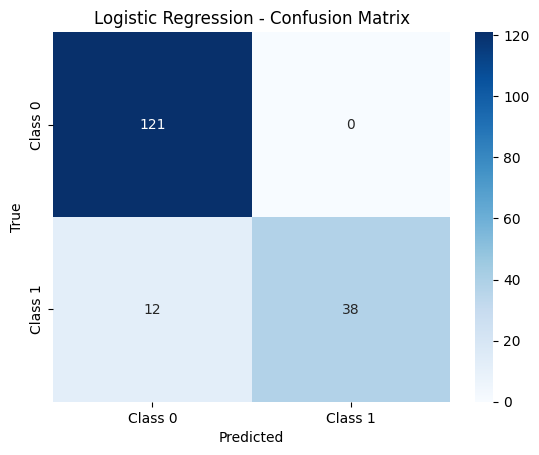


Training Random Forest...
Random Forest - ROC AUC: 0.9998, F1 Score: 0.9796


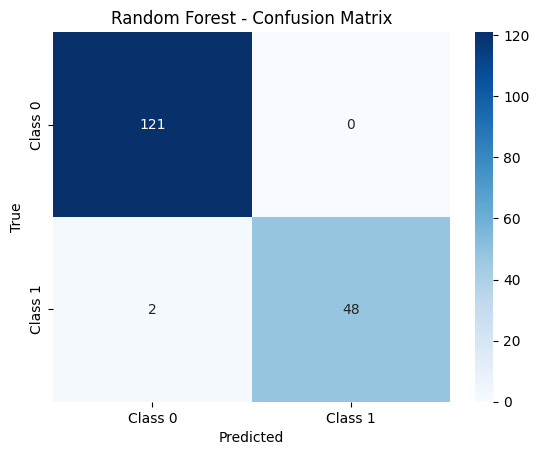


Training SVM...
SVM - ROC AUC: 0.9954, F1 Score: 0.8889


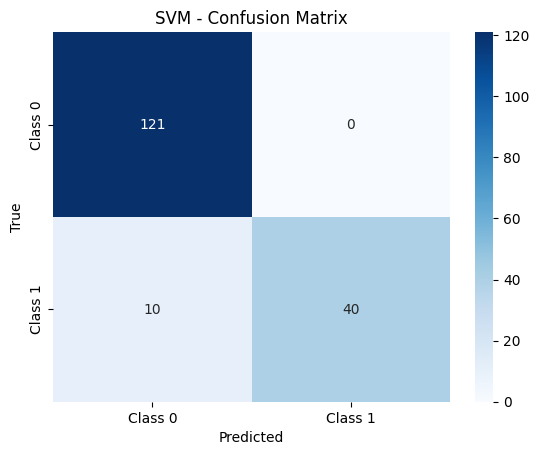


Training 1D Time Series Classifier...


ValueError: Invalid parameter 'add_first_diffs' for estimator LogisticRegression(). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].

In [19]:
# %% 
# Import necessary libraries for GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Define models for GridSearchCV (including 1D and multi-series models)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    '1D Time Series Classifier': None,  # Placeholder - replace with actual model later
    'Multi-Time Series Ensemble': None  # Placeholder - replace with actual model later
}

# Hyperparameters for GridSearchCV
param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l2', 'l1'],
        'fit_intercept': [True, False],
        'class_weight': ['balanced', None]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', None]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    },
    '1D Time Series Classifier': {
        'window_length': [15, 30],  # Example parameter for window size
        'step_length': [1],  # Example step length
        'add_first_diffs': [False]  # Whether to add first differences
    },
    'Multi-Time Series Ensemble': {
        'window_length': [15, 30],  # Example window lengths for multi-series ensemble
        'step_length': [1],
        'add_first_diffs': [True, False]  # Whether to include first differences
    }
}

# Store evaluation results for each model
model_performance = {}

# Process training and testing datasets for the multi-time series and 1D classifiers
# 1D Time Series Classifier
data_dict['1col']['X_train'], data_dict['1col']['y_train'] = processing_pipeline(
    train[-3100:-2900][['Temperature', 'Status']],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_series_input,
    add_first_diffs=False
)

data_dict['1col']['X_test'], data_dict['1col']['y_test'] = processing_pipeline(
    test[4200:4400][['Temperature', 'Status']],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_series_input,
    add_first_diffs=False
)

# Multi-Time Series Ensemble
data_dict['ts']['X_train'], data_dict['ts']['y_train'] = processing_pipeline(
    train[-3100:-2900],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_series_input,
    add_first_diffs=True
)

data_dict['ts']['X_test'], data_dict['ts']['y_test'] = processing_pipeline(
    test[4200:4400],
    window_kwargs={'window_length': 30, 'step_length': 1, 'fh': 0},
    feature_func=make_series_input,
    add_first_diffs=True
)

# Define functions for training 1D and multi-time series classifiers
from ml_pipeline.model import train_series_model, train_multiseries_model

# Train models using GridSearchCV for each model type
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    if model_name == '1D Time Series Classifier':
        # Placeholder for actual model
        grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(data_dict['1col']['X_train'], data_dict['1col']['y_train'])
        best_model = grid_search.best_estimator_

        # Store model performance for evaluation
        y_pred = best_model.predict(data_dict['1col']['X_test'])
        y_pred_proba = best_model.predict_proba(data_dict['1col']['X_test'])[:, 1]

    elif model_name == 'Multi-Time Series Ensemble':
        # Placeholder for actual model
        grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(data_dict['ts']['X_train'], data_dict['ts']['y_train'])
        best_model = grid_search.best_estimator_

        # Store model performance for evaluation
        y_pred = best_model.predict(data_dict['ts']['X_test'])
        y_pred_proba = best_model.predict_proba(data_dict['ts']['X_test'])[:, 1]

    else:  # For Logistic Regression, Random Forest, SVM
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(data_dict['stat']['X_train'], data_dict['stat']['y_train'])
        best_model = grid_search.best_estimator_

        # Store model performance for evaluation
        y_pred = best_model.predict(data_dict['stat']['X_test'])
        y_pred_proba = best_model.predict_proba(data_dict['stat']['X_test'])[:, 1]

    # Evaluate performance (ROC AUC, F1 Score)
    roc_auc = roc_auc_score(data_dict['stat']['y_test'], y_pred_proba)
    f1 = f1_score(data_dict['stat']['y_test'], y_pred)

    model_performance[model_name] = {
        'model': best_model,
        'roc_auc': roc_auc,
        'f1': f1
    }

    print(f"{model_name} - ROC AUC: {roc_auc:.4f}, F1 Score: {f1:.4f}")

    # Confusion Matrix Visualization
    conf_matrix = confusion_matrix(data_dict['stat']['y_test'], y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Select the best model based on ROC AUC and F1 Score
best_model_name = max(model_performance, key=lambda x: (model_performance[x]['roc_auc'], model_performance[x]['f1']))
best_model = model_performance[best_model_name]['model']

print(f"\nBest model based on ROC AUC and F1 Score: {best_model_name}")
print(f"Best model ROC AUC: {model_performance[best_model_name]['roc_auc']}")
print(f"Best model F1 Score: {model_performance[best_model_name]['f1']}")

# Save the best model for later use
joblib.dump(best_model, 'best_model.pkl')
